<a href="https://colab.research.google.com/github/meltyblend/Calc2Cheatsheet/blob/main/Fashion_MNIST_classifier_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Better Understanding of Image Classifiers

We will be working with the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). The CSV files came from [Kaggle.](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

The Fashion-MNIST dataset proves to be slightly more challenging than the [original MNIST dataset](http://yann.lecun.com/exdb/mnist/) of hand drawn 28x28 sized numbers.

I took heavy inspiration from [Samson Zhang](https://www.youtube.com/watch?v=w8yWXqWQYmU) . They truly kick started my desire to learn as much about neural networks as possible [link to there kaggle](https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras). Samsons guidance was very much appreciated when I first started to learn about how to make my own neural network without any fancy python libraries.




In [ ]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

import kagglehub
path = kagglehub.dataset_download("zalando-research/fashionmnist")

Using Colab cache for faster access to the 'fashionmnist' dataset.


# Forward Propagation

Information on our dataset: We are working with a dataset of images where each image has 784 pixels.

Our neural network will be very simple only utilizing only 3 layers; *Input, Hidden, and Output*.

## Input Layer

Our Input Layer is very simple. It is the image itself!

Our image has 784 pixels, each pixel holding a value from 0-255(0 = black, 255 = white).

We will feed this image into our neural network through a method known as *Forward Propagation*.

## Hidden Layer

Hidden Layers are a bit of a mystery. Understanding how many neurons you need may be difficult. Add too many neurons and you may cause *Overfitting* or your training times may get extremely slow. If you do not add enough neurons you may cause some *Underfitting*

For now to keep it simple we will stick with using only 10 neurons so that we may focus on the important and **Fun**-damental parts of a neural network!

## Output Layer

This is where our neural network will come to some sort of conclusions based on the probabilites that were outputted based on the mathematics previously performed!

Our output layer has 10 *Classifications* based on the classes provided by the Fashion-MNIST data set.

Those being: `{T-shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot}`


# Reading the Dataset

We will begin reading and testing our dataset

In [ ]:
data = pd.read_csv(path+"/fashion-mnist_train.csv")

## Taking a Peek at Our Dataset

In [ ]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# this will show the dimensions of our dataset
data.shape

(60000, 785)

We can see that we have 60,000 rows and 785 columns.

This is good, but later we will have to transpose our data so that we can work with our images as columns.

If we were to work with the dataset without transposing:
1. It would simply be very incorrect
2. Because our dataset has 60,000 that means we have 60,000 variables corresponding to images and not actual data.

So we must transpose to work with the individual pixels and there associated variables!

# Actual Coding!

We will begin by vectorizing our dataset so that we are not working directly with the csv file

In [ ]:
data_vec = np.array(data) # this makes everything in our csv into an array

# defining Rows (m) and columns (n)
m, n = data_vec.shape
# m = 60,000 n = 785

# shuffling our data like a deck of cards
# we do this because we want to be sure that the training is on a set of random
# images each time
np.random.shuffle(data_vec)

## Splitting Our Training Set

We want to split our training set. One portion will be used to for training our neural network, the other portion will be used to test.

Despite our data set providing a seperate test set, we do not want to use that test set until the very end.

Think of that last test set as the final exam for our neural network and our test set that came from splitting the training set as a midterm!

In [ ]:
# transposing the first 1000 rows from the training file
data_dev = data_vec[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255. # Normalize pixel values to be between 0 and 1

# transposing the rest of the dataset for actual training purposes
# at this point we have a training set of 59,000 images
# this is the data we will be utilizing to update weights and biases
# in our neural network
data_train = data_vec[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255. # Normalize pixel values

# Math Time!

Now that we have gotten most of the preliminary stuff out of the way, we now may dig in!

Starting with **Forward Propagation**

As we said before, our neural network has 3 layers. Now we will explain how each layer interacts with eachother mathematically!


## Transposing Our Data
Let $A^{[0]} = X$

Where,
$X =
\begin{bmatrix}
\cdots & x_1 & \cdots \\
\cdots & x_2 & \cdots \\
 & \vdots & \\
 \cdots & x_k & \cdots \\
\end{bmatrix}$

This matrix represents our original data set where
${x_1, x_2, \dots, x_n}$ represents our 60,000 rows of images, but as we stated earlier we really want this to be transposed so lets transpose it!

Let $A^{[0]} = X^T$

$X^T =
\begin{bmatrix}
\vdots & \vdots & & \vdots \\
x_1 & x_2 & \cdots & x_k \\
\vdots & \vdots & & \vdots \\
\end{bmatrix}$

Much better now!

This represents where we currently are in the code.

## Feeding Our Matrix Through the Neural Network

To feed out images through our neural network we must define a *neuron*!

**Neuron's** are a weighted sum plus some bias.

$$Z^{[l]} = W^{[l]}X^{[l-1]}+b^{[l]}$$

Since we let $A = X$ our formula becomes

$$Z^{[l]} = W^{[l]}A^{[l-1]}+b^{[l]}$$

Now this oddly looks exactly like another formula that we should all know and love. That is the formula for a line on a plane! $y = mx+b$. Its quite cumbersome knowing how simple some of the math is behind neural networks!

However, the intuition for them is extremely difficult to grasp.


### Breaking Down Our Formula

$Z^{[n]} = $ Hidden Layer Output

$W^{[n]} = $  Weights

$b^{[n]} = $ Bias

In the beginning our *Weights* and *Bias* will be chosen at random. We will go into more detail as to how we train these weights and biases to give us more accurate predictions later down the notebook.



## Finding $Z^{[1]}$ Hidden Layer Output

$Z^{[1]}$ corresponds to our first *Hidden Layer* output

$$Z^{[1]} = W^{[1]}A^{[0]} + b^{[1]}$$

Lets take a look at the dimensions of our matrices and vectors in the formula

$$Z^{[1]} = dim(W^{[1]})dim(A^{[0]}) + dim(b^{[1]})$$

$$Z^{[1]} = (10 \times 784)(784 \times k) + (10 \times 1)$$

Where $k$ is the number of images being passed through the neural network.

$$= (10 \times k) + (10 \times 1)$$

$$Z^{[1]} = (10 \times k)$$

In the end we are left with the output of our *Hidden Layer* matrix.



## Activation Functions

*Activation Functions* are what makes the math *non-linear* meaning we are going to apply a function to our $Z^{[1]}$ output to make our linear function into something curvy so that later on we can find a nice happy little descent that will give us our (hopefully) desired answer.


There are a few Activation Functions however, we will be dealing with *ReLU* (Rectified Linear Unit)

$$ReLU(x) = \max(0,x)=
\begin{cases}
x, & \text{if } x > 0 \\
0, & \text{if } x \leq 0
\end{cases}
$$

In essence we are utilizing ReLU to create a vector of non-negative numbers.

We now will apply $ReLU$,

$A^{[1]} = ReLU(Z^{[1]})$

$$A^{[1]} =
\begin{bmatrix}
\max(0,z_{11}^{[1]}) & \max(0,z_{12}^{[1]}) & \dots & \max(0,z_{1j}^{[1]}) \\
\max(0,z_{21}^{[1]}) & \max(0,z_{22}^{[1]}) & \dots & \max(0,z_{2j}^{[1]}) \\
\vdots & \vdots & \ddots & \vdots \\
\max(0,z_{i1}^{[1]}) & \max(0,z_{i2}^{[1]}) & \dots & \max(0,z_{ij}^{[1]}) \\
\end{bmatrix}
$$

$dim(Z^{[1]}) = dim(A^{[1]})$

Thus making our *Hidden Layer* output non-linear and ready for to be used for our next layer

### Graph of ReLU
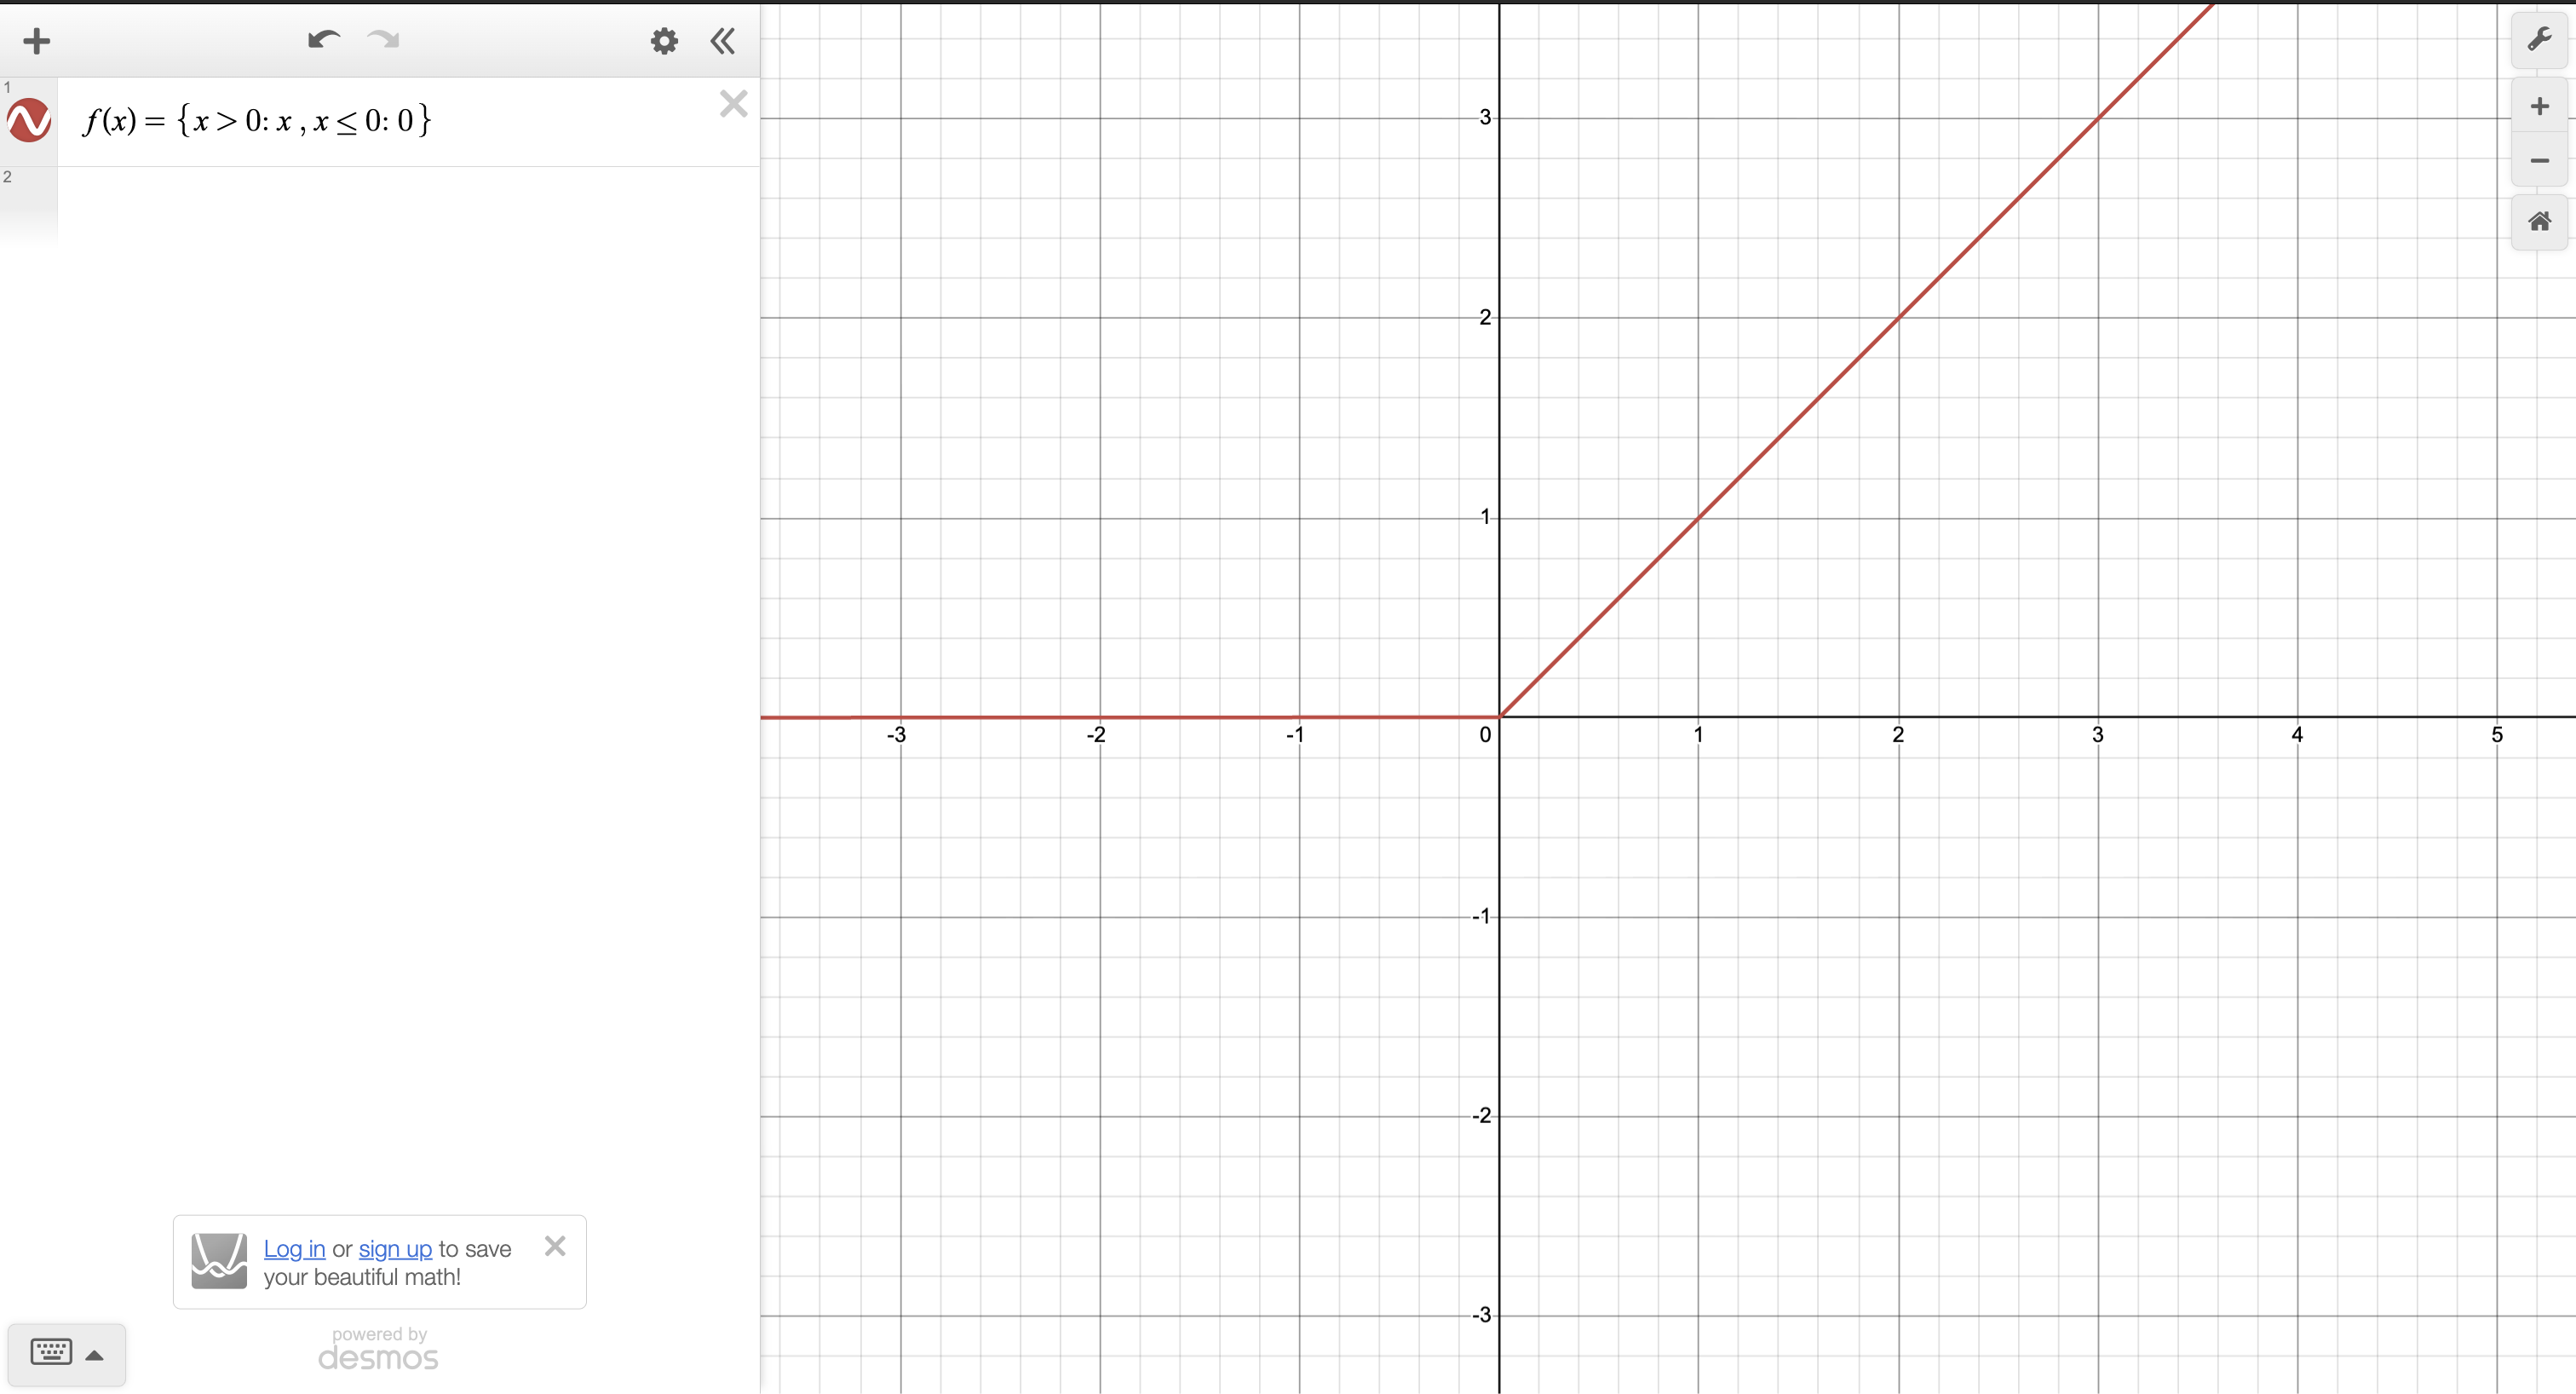

## Finding $Z^{[2]}$ Output Layer Output

We must repeat the process similarly to how we found $Z^{[1]}$

$$Z^{[2]} =  W^{[2]}A^{[1]} + b^{[2]}$$

$$ = (10 \times 10) (10 \times k) + (10 \times 1)$$

$$= (10 \times k)$$

Thus, giving us the output of our Output Layer.

However, if we take a closer look at our output (for the time being lets assume $k = 1$ which means we are looking at a single image)

$dim(Z^{[2]}) = (10 \times 1)$

$$Z^{[2]} =
\begin{bmatrix}
z_1 \\
z_2 \\
\vdots \\
z_k
\end{bmatrix}
$$

Each element within this vector will now tell us a probabiliy of what the neural network believes that the image may be classified as.

However, the results are not particualarly what we are looking for so we must normalize the vector by introducing the *Softmax* function

## Softmax Function


The *Softmax* function helps us further interpret our probabilites of which classification our neural network believes that the input image may be.

$$Softmax(Z^{[2]}) = \hat{y}_i = \dfrac{e^{Z_i^{[2]}}}{\sum_{j=1}^{10} e^{Z_j^{[2]}}}$$

To those with a keen eye, you may have noticed that this function will normalize our data so that the sum of each element wil equal 1.

This helps us better interpret the probability of whether the image is of `Trousers` or of a `T-shirt`

We are exponentiating each element in $Z^{[2]}$ then dividing them by the exponentiation of each element summed!

$$Softmax(Z^{[2]}) = \dfrac{1}{e^{z_1} + e^{z_2} + \dots + e^{z_{10}}}
\begin{bmatrix}
e^{z_1} \\
e^{z_2} \\
\vdots \\
e^{z_{10}}
\end{bmatrix}
$$

If you take an even closer look you should have noticed that we are dividing by the **Manhattan Norm** or the **$L_1$ Norm**

# Coding Forward Propagation!!! Finally!!!

## Initializing Parameters

First we will begin by making a function that initializes our *Weights* and *Biases*

In [ ]:
def init_params():
  # for the first layer (Hidden Layer)
  W1 = np.random.rand(10,784) - 0.5
  b1 = np.random.rand(10,1) - 0.5

  # for the second layer (Output Layer)
  W2 = np.random.rand(10,10) - 0.5
  b2 = np.random.rand(10,1) - 0.5
  return W1, b1, W2, b2

In the beginning we want our *Weights* and *Biases* to have some values. So we choose them to have random values between $[0,1]$.

**Example** of what the first line in the funciton is doing

`W1` Has 10 rows 784 columns where each element is a random value sitting between 0 and 1

Since we are subtracting by 0.5 we are shifting each element to be centered around 0

If our smallest element is 0 then $0 - 0.5 = -0.5$

If our largest element is 1 then $1 - 0.5 = 0.5$

Therefore, our new interval for all numbers are  between $[-0.5,0.5]$

We want this as when we apply our *Activation Function* we can ignore the values that are negative, the negative values imply that the neural network believes theyre strongly not a part of that classification.  

# Activation Functions

Before we begin our *Forward Propagation* We need to create our *Activation Functions*

In [ ]:
# this is precisely what we defined earlier
# we compare each element to 0
# x, x > 0
# 0, x <=0
def relu(Z):
  return np.maximum(0,Z)


# Softmax Function

This is our softmax function. Again, This will make every sit somewhere between $[0,1]$ where the sum of all elements after the softmax function is applied is equal to $1$

In [ ]:
# exactly how we defined our softmax function previously
def softmax(Z):
  # Subtract max for numerical stability to prevent overflow
  Z = Z - np.max(Z, axis=0, keepdims=True)
  A = np.exp(Z) / np.sum(np.exp(Z), axis=0, keepdims=True)
  return A

# Forward Propagation

This is where we tie everything together and how feeding our image through the neural network works.

In [ ]:
def forward_prop(W1, b1, W2, b2, X):
  # output of our first layer (Hidden Layer)
  Z1 = W1.dot(X) + b1

  # making our output non-linear using ReLU
  A1 = relu(Z1)

  # feeding our non-linear A1 to the next layer (Output Layer)
  Z2 = W2.dot(A1) + b2

  # using softmax to truly determine what the neural network believes
  # the image may be classified as at the moment
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

This is how the math looks for the `forward_prop` function

$$
\begin{aligned}
X \rightarrow Z^{[1]}: Z^{[1]} = W^{[1]} A^{[0]} + b^{[1]} \\
Z^{[1]} \rightarrow A^{[1]} : A^{[1]}=ReLU(Z^{[1]}) \\
A^{[1]} \rightarrow Z^{[2]} : Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\\
Z^{[2]} \rightarrow A^{[2]} : A^{[2]} = Softmax(Z^{[2]})
\end{aligned}
$$

After the *Softmax* Our vector of a single image passing through the *Forward Propagation* will look something like this

$$
\begin{aligned}
Softmax(Z^{[2]}) = \dfrac{e^{Z^{[2]}}}{∑e^{Z^{[2]}}} \\
= \dfrac{1}{e^{z_1} + e^{z_2} + \dots + e^{z_{10}}}
\begin{bmatrix}
e^{z_1} \\
e^{z_2} \\
\vdots \\
e^{z_{10}}
\end{bmatrix}
\end{aligned}
$$

At the moment all we have is some random prediction. We do not know if it is correct at, so we must implement a *Cost Function*


# One-Hot Encoding

One-Hot Encoding is a method for converting categorical labels such as `{T-shirt/Top, Boots, ..., etc.}`into quantative data so that it may be processed by our neural network.

We set our vectors elements all to $0$ however, we leave one element set to $1$ to represent where in the classifier list we are at.

For example, say we are dealing with an image of `{Boots}` then our vector will look like:

$\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$


The columns represent our Classification and the rows represent the number of images inputted.

We then transpose the vector so that we may be able to do math more easily with it.


$Y \rightarrow Y_{One-Hot}:
\begin{bmatrix}
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
\end{bmatrix}
$

In [ ]:
def one_hot(Y):

  # here we create a matrix full of 0
  # rows = Y.size
  # cols = Y.max() + 1 = 10
  one_hot_Y = np.zeros((Y.size, Y.max() + 1 ))

  # This is how we will set an element in the matrix to 1
  # np.arange takes in number of images = y.size
  # then this line will go through to every row at column Y
  # and set that element to 1 to represent what that row will
  # classified as
  one_hot_Y[np.arange(Y.size), Y] = 1

  return one_hot_Y.T

# Backpropagation

["Backpropagation is a gradient computation method commonly used for training neural networks in computing parameter updates"](https://en.wikipedia.org/wiki/Backpropagation)

After our first *Forward pass* the corresponding output will mostlikely be incorrect as we had choosen random elements for the *Weights* and *Biases* vectors.

Doing this *Backpropagation* method is what will give us more accurate results as we will now be updating our *Weights* and *Biases* through each pass.








## Underlying Math for Backpropagation



Backpropagation allows for us to understand how the weights and the biases in a neural network change in order to make more accurate predictions as training continues.

We change these weights and biases by computing derivatives via the ***chain rule*** and ***Gradien Descent***.



### How Backprop Algorithm Works

When building our backpropagation algorithm, we care about three things: Error in our *Output Layers* $Z^{[1]},Z^{[2]}$ the *weights* and *biases* associated with that layer $W^{[1]},W^{[2]},b^{[1]},b^{[2]}$



The computation to find the derivatives are a little invloved, for now we will skipe them. However, if you desire to see them the following material helped me understand them from mathematics stand point:

[The Matrix Calculus You Need For Deep Learning](https://arxiv.org/pdf/1802.01528)

[The Complete Mathematics of Neural Networks and Deep Learning](https://www.youtube.com/watch?v=Ixl3nykKG9M)


[How the backpropagation algorithm works](http://neuralnetworksanddeeplearning.com/chap2.html)

[An Overview Of Artificial Neural Networks for
Mathematicians](https://math.uchicago.edu/~may/REU2018/REUPapers/Guilhoto.pdf)

### Output layer Gradients

#### Error of $dZ^{[2]}$:

$$
\begin{aligned}
dZ^{[2]} = A^{[2]} - Y_{one\_ hot}
\end{aligned}
$$

#### Weights Gradient $dW^{[2]}$:
$$
\begin{aligned}
dW^{[2]} = \dfrac{1}{m} \cdot dZ^{[2]} A^{[1]T}
\end{aligned}
$$

#### Bias Gradient $dW^{[2]}$:
$$
\begin{aligned}
db^{[2]} = \dfrac{1}{m} \sum dZ^{[2]}
\end{aligned}
$$

## ReLU Derivative
Let us take a look back at our *Activation Function*.
$$ReLU(x) = \max(0,x)=
\begin{cases}
x, & \text{if } x > 0 \\
0, & \text{if } x \leq 0
\end{cases}
$$

More clearly we see that when $x > 0 \rightarrow f(x) = x$ and $x \leq 0 \rightarrow f(x) = 0$


Therefore, the derivative of the functions comprising $ReLU$ are trivial.

$f'(x) = 1, \qquad f'(x) = 0$

$$ReLU'(x)=
\begin{cases}
1, & \text{if } x > 0 \\
0, & \text{if } x \leq 0
\end{cases}
$$






In [ ]:
# if an element in Z is greater than 0
# return 1 else return 0
def relu_deriv(Z):
  return Z > 0

### Hidden Layer Gradients

#### Error of $dZ^{[1]}$:

$$
\begin{aligned}
dZ^{[1]} = W^{[2]T} dZ^{[2]} \odot ReLU'(Z^{[1]})
\end{aligned}
$$

#### Weights Gradient $dW^{[1]}$:
$$
\begin{aligned}
dW^{[1]} = \dfrac{1}{m} \cdot dZ^{[1]} A^{[0]T}
\end{aligned}
$$

#### Bias Gradient $dW^{[2]}$:
$$
\begin{aligned}
db^{[1]} = \dfrac{1}{m} \sum dZ^{[1]}
\end{aligned}
$$

# Backprop Code

In [ ]:
def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
  m = Y.size # batch size

  # calling our one_hot function
  one_hot_Y = one_hot(Y)

  # our output layer error
  #
  # predicted probabilities minus our One-Hot vector
  # the difference between what the network predicted and the actual answer
  dZ2 = A2 - one_hot_Y

  # we take the error and multiply it by the input that created it
  # then we transpose so the the multiplication works
  dW2 = 1 / m * dZ2.dot(A1.T)

  # since the bias is added to every single example in the batch its gradient
  # is the avg of the errors from all examples
  # Sum across the batch (axis 1) to get a column vector
  db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

  # our hiddent layer error
  #
  # these lines do the same thing however this time we now also must find
  # derivative of ReLU
  # the derivative of ReLU essentially gets rid of the gradient if Z1 < 0
  # this tells us that that it had no contribution towards our prediction
  #
  # later talk about how negative probability means the neural net thinks that
  # that element had 0 contribution in determining what the classification of
  # the image is
  dZ1 = W2.T.dot(dZ2) * relu_deriv(Z1)

  dW1 = 1 / m * dZ1.dot(X.T)
  db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

  return dW1, db1, dW2, db2

## Updating Parameters



Work on this part need to talk about this


In [ ]:
def update_param(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
  W1 = W1 - alpha * dW1
  b1 = b1 - alpha * db1
  W2 = W2 - alpha * dW2
  b2 = b2 - alpha * db2
  return W1, b1, W2, b2

## Getting Predictions and accuracy


In [ ]:
def get_predictions(A2):
  return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
  print(predictions, Y)
  return np.sum(predictions == Y) / Y.size

# Gradient Descent

In [ ]:
def grad_descent(X, Y, alpha, iterations):
  W1, b1, W2, b2 = init_params()
  for i in range(iterations):
    Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
    W1, b1, W2, b2 = update_param(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
    if i % 10 == 0:
      print("Iteration: ", i)
      print("")
      predictions = get_predictions(A2)
      print(get_accuracy(predictions, Y))
  return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = grad_descent(X_train, Y_train, 0.10, 500)

Iteration:  0

[9 9 8 ... 9 9 9] [5 0 5 ... 6 2 5]
0.0879322033898305
Iteration:  10

[5 4 9 ... 3 5 5] [5 0 5 ... 6 2 5]
0.20320338983050848
Iteration:  20

[5 4 9 ... 3 5 5] [5 0 5 ... 6 2 5]
0.3062033898305085
Iteration:  30

[5 1 9 ... 2 5 5] [5 0 5 ... 6 2 5]
0.38372881355932204
Iteration:  40

[5 1 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.42410169491525423
Iteration:  50

[5 4 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.45196610169491525
Iteration:  60

[5 4 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.4706101694915254
Iteration:  70

[5 4 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.4932372881355932
Iteration:  80

[5 0 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.5132203389830509
Iteration:  90

[5 0 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.5339322033898305
Iteration:  100

[5 0 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.552728813559322
Iteration:  110

[5 0 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.5688813559322033
Iteration:  120

[5 0 9 ... 2 8 5] [5 0 5 ... 6 2 5]
0.5810338983050848
Iteration:  130

[5 0 9 ... 2 6 5] [5 0 5 ... 6 2 5]
0.5913220338983051


# Our Models Accuracy on the training set

It looks like our model is $\approx 75\% $ accurate in accordance to our training set

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]

    print("Prediction: ", class_names[prediction[0]])
    print("Label: ", class_names[label])

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  Sandal
Label:  Sandal


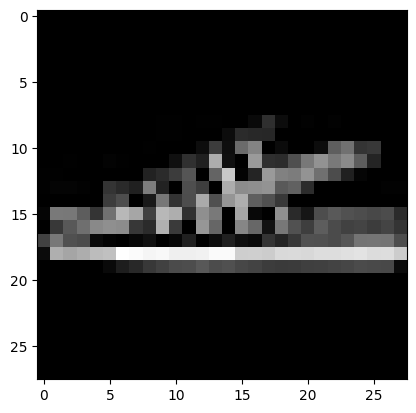

Prediction:  T-shirt/top
Label:  T-shirt/top


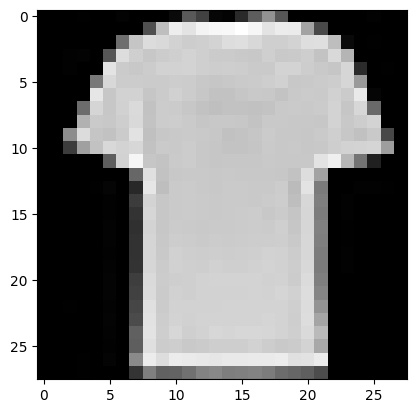

Prediction:  Ankle boot
Label:  Sandal


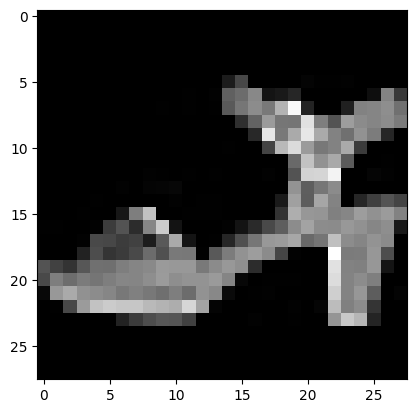

Prediction:  Sandal
Label:  Sandal


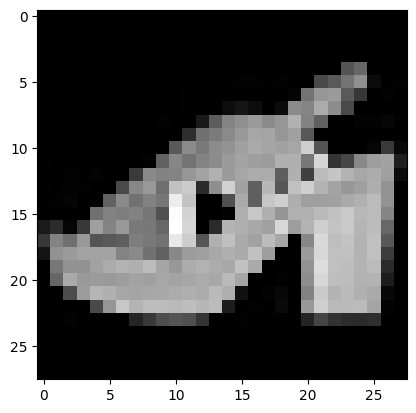

Prediction:  T-shirt/top
Label:  Shirt


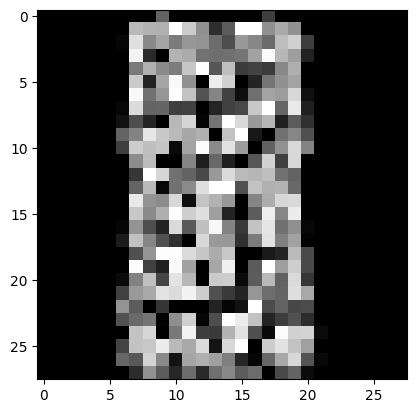

Prediction:  Shirt
Label:  Shirt


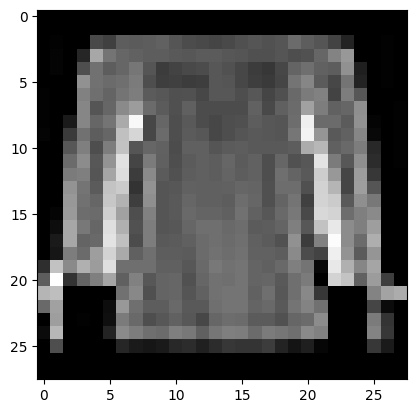

Prediction:  Coat
Label:  Pullover


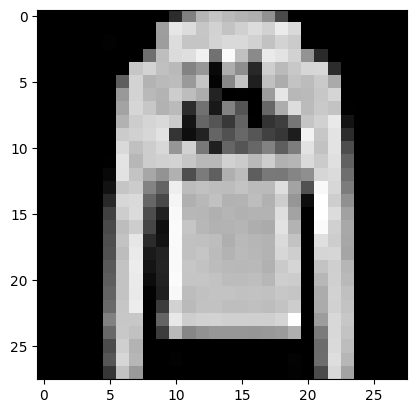

Prediction:  Shirt
Label:  T-shirt/top


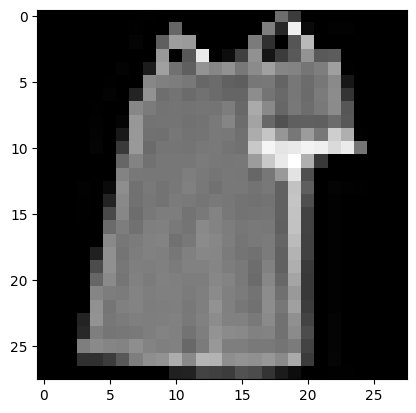

Prediction:  Coat
Label:  Coat


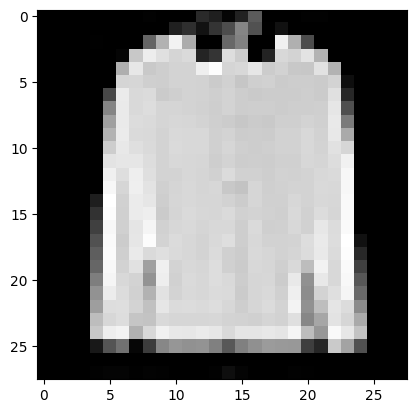

Prediction:  Trouser
Label:  Trouser


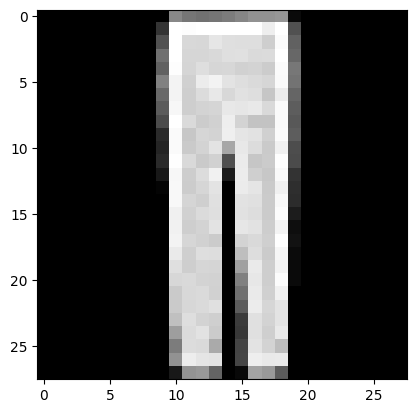

In [ ]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(4, W1, b1, W2, b2)
test_prediction(5, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(7, W1, b1, W2, b2)
test_prediction(8, W1, b1, W2, b2)
test_prediction(9, W1, b1, W2, b2)


# Testing our Test Set

In [ ]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[3 1 5 9 1 0 0 3 4 0 8 5 8 3 8 1 3 0 0 3 1 4 4 0 9 6 9 3 3 8 1 5 0 8 9 8 7
 5 5 3 3 1 4 1 3 1 7 3 9 4 4 1 3 1 0 1 8 1 3 9 3 3 9 7 3 5 0 4 4 5 9 8 0 0
 9 1 7 8 6 6 4 3 3 5 8 4 9 0 6 5 8 3 2 4 3 8 8 7 7 3 5 7 6 1 3 7 9 1 9 4 7
 7 3 0 3 1 2 5 9 1 6 9 6 5 3 5 4 6 7 8 6 7 3 4 6 6 0 4 5 3 4 0 6 0 7 3 2 4
 4 4 0 6 4 6 7 3 4 8 6 1 4 7 4 6 8 4 4 9 0 1 8 7 8 9 1 3 3 0 4 5 2 3 8 4 3
 5 1 4 2 5 9 1 6 5 4 2 9 3 3 9 8 5 3 9 3 9 6 7 1 4 1 8 7 6 1 6 3 9 4 3 9 4
 0 1 2 2 5 1 4 7 4 3 7 1 6 6 8 9 5 9 7 4 7 2 7 1 4 6 4 3 6 7 1 6 6 8 0 6 4
 3 7 6 0 9 5 6 4 8 4 7 4 4 4 8 8 7 3 4 3 3 0 4 7 8 7 9 3 1 4 4 0 1 1 9 6 8
 7 9 1 0 6 2 8 5 9 4 3 3 4 1 6 9 8 3 8 3 8 4 6 9 9 6 0 4 3 1 5 9 8 5 3 4 4
 6 0 7 3 4 2 2 4 4 4 1 6 4 9 1 8 4 8 5 8 5 2 1 6 4 8 8 4 3 7 6 0 6 0 1 6 3
 4 3 5 3 4 3 2 5 4 3 6 9 3 0 8 8 1 9 4 1 1 7 1 8 6 6 0 8 5 2 9 7 3 6 1 3 5
 4 7 8 0 7 4 6 9 9 6 4 9 3 7 7 6 9 1 1 1 9 7 2 4 3 2 5 5 5 1 7 0 2 2 8 2 7
 7 3 3 9 9 0 4 3 5 5 4 1 7 6 4 0 6 5 6 1 4 4 8 9 4 0 1 6 8 5 0 2 3 8 4 6 7
 4 3 7 3 4 4 2 2 3 0 4 8 

np.float64(0.689)

 Therefore, our CNN is $\approx 70 \%$ accurate